# Doggo Data Wrangling

## Table of Contents
<ul>
<li><a href="#Introduction">Introduction</a></li>
<li><a href="#Gather">Gather</a></li>
<li><a href="#Tidiness">Tidiness</a></li>
<li><a href="#Quality">Quality</a></li>
<li><a href="#Store">Store</a></li>
<li><a href="#Analysis">Analysis</a></li>
</ul>

# Introduction

> We are going to gather data from three different sources: 1) an archive of tweet information that we have on file, 2) image content predictions (from a neural net) stored online, and 3) additional tweet information via the Twitter API. We will then assess the tidiness of the collected data sets, and remedy any important problems for our project. Next, we will assess the quality of the newly tidied data set, and address significant issues. (It seemed easier to address the quality problems after the data was tidied.) Then we will store the cleaned data set to file. Finally, we will perform some analysis to answer a few interesting questions from the data set.

# Gather

In [1]:
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import time
from io import StringIO
import os.path
import requests
import json
import tweepy

## Data Source 1

In [2]:
df_tweets = pd.read_csv('twitter-archive-enhanced.csv')
df_tweets.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


## Data Source 2

In [3]:
predictions_url = (
    'https://d17h27t6h515a5.cloudfront.net/' +
    'topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
)
response = requests.get(predictions_url)
with open('image-predictions.tsv', 'w+') as f:
    f.write(response.text)
df_predictions = pd.read_csv(StringIO(response.text), delimiter='\t')
df_predictions.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [4]:
tweet_ids = df_tweets.tweet_id.tolist()
set(tweet_ids).issuperset(set(df_predictions.tweet_id.tolist()))

True

## Data Source 3

In [5]:
def twitter_tokens():
    with open('passwords.txt', 'r') as file:
        pwd_str = file.read()
        return pwd_str.split(',')


def twitter_api_connection():
    (api_key, api_secret, access_token, access_secret) = twitter_tokens()
    auth = tweepy.OAuthHandler(api_key, api_secret)
    auth.set_access_token(access_token, access_secret)
    api = tweepy.API(
        auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True
    )
    return api


# From https://stackoverflow.com/a/312464/576101.
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


def write_tweets_with_ids_to_new_file(tweet_ids, file_name):
    if not os.path.isfile(file_name):
        api = twitter_api_connection()
        with open(file_name, 'w+') as file:
            for tweet_id_chunk in chunks(tweet_ids, 100):
                tweets = api.statuses_lookup(tweet_id_chunk)
                for tweet in tweets:
                    file.write(json.dumps(tweet._json) + '\n')


write_tweets_with_ids_to_new_file(tweet_ids, 'tweets_json.txt')

In [6]:
# Keep only the fields we care about.
json_fields = [
    'id',
    'favorite_count',
    'retweet_count'
]
df_json_full = pd.read_json('tweets_json.txt', lines=True)
df_json = df_json_full[json_fields]
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 3 columns):
id                2342 non-null int64
favorite_count    2342 non-null int64
retweet_count     2342 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


# Tidiness

## Assess

> We will take a look at all of the columns in each data frame, and proceed column by column looking for issues. Columns without any issues may not be commented on.

### df_tweets

In [7]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [8]:
df_tweets.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [9]:
# Only 4 unique source values -- let's investigate.
df_tweets.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

* The `source` field contains two separate variables: source url and source title, which together could be thought of as forming a separate observational unit type. The rest of the content is the same between the four unique values for `source`.

* We could think of rating as one value (rating_numerator divided by rating_denominator), but there may be something of interest in the particular denominator and numerator choices. It is not clear to me if this separation should be considered a violation of tidy data's requirement of a one-to-one mapping between columns and variables.

> The `doggo`, `floofer`, `pupper`, and `puppo` fields perhaps are values rather than variables. The variable would be something like `dog_type`. That's assuming that every dog has at most one category associated with it. Let's test that proposition.

In [10]:
(df_tweets[['doggo', 'floofer', 'pupper', 'puppo']]
 .replace('None', '')
 .apply(lambda row: ''.join(map(str, list(row.values))), axis=1)
).unique()

array(['', 'doggo', 'puppo', 'pupper', 'floofer', 'doggopuppo',
       'doggofloofer', 'doggopupper'], dtype=object)

> Ok, it turns out that some dogs have more than one type. Hence, these columns are separate variables.

### df_predictions

In [11]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [12]:
df_predictions.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

In [13]:
df_predictions.sample(4)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
739,687127927494963200,https://pbs.twimg.com/media/CYkrNIVWcAMswmP.jpg,1,pug,0.178205,True,Chihuahua,0.149164,True,Shih-Tzu,0.120505,True
1905,852226086759018497,https://pbs.twimg.com/ext_tw_video_thumb/85222...,1,prison,0.352793,False,dishwasher,0.110723,False,file,0.094112,False
495,675740360753160193,https://pbs.twimg.com/ext_tw_video_thumb/67574...,1,golden_retriever,0.800495,True,kuvasz,0.097756,True,Saluki,0.068415,True
791,690690673629138944,https://pbs.twimg.com/media/CZXTgKkWwAA5UZJ.jpg,1,bath_towel,0.194532,False,radiator,0.127776,False,Maltese_dog,0.089625,True


* The nine fields for p1, p2, and p3 can be mapped to just four variables: predicted_label, prediction_confidence, predicted_is_dog, and prediction_num (holding a value of 1, 2, or 3).
* Alternatively, we could see each observational unit here as summary data about each tweet, which matches the observational unit type of `df_tweets`.

### df_json

In [14]:
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 3 columns):
id                2342 non-null int64
favorite_count    2342 non-null int64
retweet_count     2342 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


* `df_json` and `df_tweets` are of the same observational unit type -- summary data about a tweet.

## Summary

### df_tweets

* The `source` field contains two separate variables: source url and source title, which together could be thought of as forming a separate observational unit type. The rest of the content is the same between the four unique values for `source`. However, it's not clear that making a change here makes any subsequent analysis more convenient.
* We could think of rating as one value (`rating_numerator` divided by `rating_denominator`), but there may be something of interest in the particular denominator and numerator choices.

### df_predictions

* The nine fields for `p1`, `p2`, and `p3` can be mapped to just four variables: predicted_label, prediction_confidence, predicted_is_dog, and prediction_num (holding a value of 1, 2, or 3).
* Alternatively, we could see each observational unit here as summary data about each tweet, which matches the observational unit type of `df_tweets`.

### df_json

* `df_json` and `df_tweets` are of the same observational unit type -- summary data about a tweet.


## Clean

### df_tweets

* Create a new field called `rating` from `rating_numerator` / `rating_denominator`, while still retaining those individual fields.

In [15]:
df_tweets_tidy = df_tweets.copy()
df_tweets_tidy['rating'] = (
    df_tweets_tidy['rating_numerator'] / df_tweets_tidy['rating_denominator']
)
np.array(sorted(df_tweets_tidy.rating.unique()))

array([0.00000000e+00, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
       4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 6.36363636e-01,
       7.00000000e-01, 7.33333333e-01, 8.00000000e-01, 8.18181818e-01,
       9.00000000e-01, 1.00000000e+00, 1.10000000e+00, 1.20000000e+00,
       1.25000000e+00, 1.30000000e+00, 1.40000000e+00, 1.50000000e+00,
       1.70000000e+00, 2.60000000e+00, 2.70000000e+00, 3.42857143e+00,
       7.50000000e+00, 1.82000000e+01, 4.20000000e+01, 6.66000000e+01,
       1.77600000e+02,            inf])

### df_predictions

* Merge `df_predictions` with `df_tweets`.

In [16]:
df_tweets_tidy = df_tweets_tidy.merge(df_predictions, how='left')
df_tweets_tidy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 29 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
rating                        23

### df_json

* Merge `df_json` with `df_tweets`.

In [17]:
df_tweets_tidy = df_tweets_tidy.merge(
    df_json.rename(columns={'id': 'tweet_id'}), how='left'
)
df_tweets_tidy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 31 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
rating                        23

# Quality

## Assess

* According to the project requirements and mentor clarification in the Student Hub (https://bit.ly/2AEXRlQ), both retweets and replies are not needed. Thus, any rows with non-null values in the following columns are unnecessary (and the columns could then be dropped): `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp`.

In [18]:
# Check if timestamp is in a date format.
df_tweets_tidy.timestamp.dtype

dtype('O')

* The date type of `timestamp` is not a date format.

In [19]:
# Check if timestamps fall within a reasonable timeframe.
df_tweets_tidy.timestamp.min(), df_tweets_tidy.timestamp.max()

('2015-11-15 22:32:08 +0000', '2017-08-01 16:23:56 +0000')

> Yes, these are acceptable dates.

In [20]:
# Are any of the dates in a different format?
date_format_regex = '^201[567]-[\d]{2}-[\d]{2} [\d]{2}:[\d]{2}:[\d]{2} \+0000$'
(~df_tweets_tidy.timestamp.str.contains(date_format_regex)).sum()

0

> No other date formats to worry about here.

In [21]:
df_tweets_tidy.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

* There are only 4 possible values for `source`. A categorical data type might be a good idea here.

In [22]:
# Check on name column values.
df_tweets_tidy.name.value_counts()[:10]

None       745
a           55
Charlie     12
Oliver      11
Cooper      11
Lucy        11
Penny       10
Tucker      10
Lola        10
Bo           9
Name: name, dtype: int64

* The column name for the dog's name is `name`, which is not very explicit in meaning.

* `None` is being used instead of null here. And there are a lot of nulls.

* The `a` name does not seem correct. Perhaps some mistakes were made with extracting names from tweets. Let's investigate this issue a little more.

In [23]:
df_tweets_tidy[df_tweets_tidy.name == 'a'].text.head(5).unique()

array(['Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF',
       'Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq',
       'Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn',
       'This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW',
       'Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R'],
      dtype=object)

* Apparently in some cases the name was missed in extraction ("Forrest"), and in some cases there is actually no name given in the tweet. This would be worth investigating more if we care a lot about using the `name` field for our analysis later, but could entail a lot of unnecessary work if not.

In [24]:
df_tweets_tidy[['doggo', 'floofer', 'pupper', 'puppo']].head(5)

,doggo,floofer,pupper,puppo
0,None,None,None,None
1,None,None,None,None
2,None,None,None,None
3,None,None,None,None
4,None,None,None,None


* The dog type column values contain the string `None` for null.

In [25]:
df_tweets_tidy[['doggo', 'floofer', 'pupper', 'puppo']].replace('None', np.NaN).dropna(thresh=1)[:10]

,doggo,floofer,pupper,puppo
9,doggo,NaN,NaN,NaN
12,NaN,NaN,NaN,puppo
14,NaN,NaN,NaN,puppo
29,NaN,NaN,pupper,NaN
43,doggo,NaN,NaN,NaN
46,NaN,floofer,NaN,NaN
49,NaN,NaN,pupper,NaN
56,NaN,NaN,pupper,NaN
71,NaN,NaN,NaN,puppo
78,NaN,NaN,pupper,NaN


* The dog type column values contain `doggo` etc for the non-null values (redundant). These columns could be simplified to have a boolean data type.

In [26]:
# Let's take a look at the ratings.
pd.options.display.max_columns = 100
(df_tweets_tidy[['rating_numerator', 'rating_denominator', 'tweet_id']]
 .groupby(['rating_denominator', 'rating_numerator'])
 .count().rename(columns={'tweet_id': 'count'}).T
)

rating_denominator  0    2    7    10                                      \
rating_numerator   960  1    24   0    1    2    3    4    5    6    7      
count                 1    1    1    2    8    9   19   15   37   32   54   

rating_denominator                                                         \
rating_numerator   8    9    10   11   12   13   14   15   17   26   27     
count               102  156  461  463  558  351   54    2    1    1    1   

rating_denominator                           11        15   16   20   40   \
rating_numerator   75   182  420  666  1776 7    9    11   20   4    44     
count                 2    1    2    1    1    1    2    1    1    2    1   

rating_denominator  50             70   80        90   110  120  130  150  170  
rating_numerator   45   50   60   84   80   88   99   121  144  143  165  204   
count                 1    1    1    1    1    1    1    1    1    1    1    1

In [27]:
# Let's sanity check the accuracy a little bit.
def extract_ratings():
    return (
        df_tweets_tidy
        .text.str.extract('((?:[\d]+\.)?[\d]+)/((?:[\d]+\.)?[\d]+)')
        .rename(columns={0: 'sanity_numerator', 1: 'sanity_denominator'})
    )


df_ratings_check = extract_ratings()
df_ratings_check = pd.concat([df_tweets_tidy[['rating_numerator', 'rating_denominator', 'tweet_id', 'text']], df_ratings_check], axis=1)
df_ratings_mismatches = df_ratings_check[(df_ratings_check.rating_numerator.astype(float) != df_ratings_check.sanity_numerator.replace('', 0).astype(float)) | (df_ratings_check.rating_denominator.astype(float) != df_ratings_check.sanity_denominator.replace('', 0).astype(float))]
df_ratings_mismatches

,rating_numerator,rating_denominator,tweet_id,text,sanity_numerator,sanity_denominator
45,5,10,883482846933004288,This is Bella. She hopes her smile made you sm...,13.5,10
340,75,10,832215909146226688,"RT @dog_rates: This is Logan, the Chow who liv...",9.75,10
695,75,10,786709082849828864,"This is Logan, the Chow who lived. He solemnly...",9.75,10
763,27,10,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. ...,11.27,10
1689,5,10,681340665377193984,I've been told there's a slight possibility he...,9.5,10
1712,26,10,680494726643068929,Here we have uncovered an entire battalion of ...,11.26,10


> Apparently, we've got 6 mismatches, only when the numerator is non-integer. Let's examine the full text to be sure.

In [28]:
df_ratings_mismatches.text.unique()

array(['This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948',
       "RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",
       "This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",
       "This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq",
       "I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace",
       'Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD'],
      dtype=object)

> It is confirmed that the ratings for these entries are incorrect and that the alternative extraction method is correct.

In [29]:
df_tweets_tidy.rating.sort_values(ascending=False)[:15]

313            inf
979     177.600000
189      66.600000
2074     42.000000
188      42.000000
290      18.200000
340       7.500000
695       7.500000
516       3.428571
763       2.700000
1712      2.600000
55        1.700000
285       1.500000
291       1.500000
64        1.400000
Name: rating, dtype: float64

> We don't need any rows lacking an image.

> The `p1_dog`, `p2_dog`, and `p3_dog` columns have an object data type instead of boolean.

## Summary

* Any rows with non-null values in the following columns are unnecessary (and the columns are then also unnecessary): `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp`.
* The date type of `timestamp` is not a date format.
* There are only 4 possible values for `source`. A categorical data type might be a good idea here.
* The column name for the dog's name is `name`, which is not very explicit in meaning.
* The `name` column contains a lot of nulls.
* `None` is being used for entries of `name` instead of null.
* In some cases the dog name was missed in extraction ("Forrest"), and in some cases there is actually no name given in the tweet. It would probably take a bit of effort to extract more names, and we still can't get all of them.
* The dog type column values contain the string `None` for null.
* The dog type column values contain `doggo` etc for the non-null values (redundant). These columns could be simplified to have a boolean data type.
* We've got 6 incorrect ratings when the numerator is non-integer.
* We don't need any rows lacking an image.
* The `p1_dog`, `p2_dog`, and `p3_dog` columns have an object data type instead of boolean.

## Clean

### Define
* Remove all rows with non-null values for the following columns: `in_reply_to_status_id` or `retweeted_status_id`.
* Remove the following columns: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp`.
* Change the data type of `timestamp` to date.
* Change the data type of `source` to categorical.
* Remove the `name` column.
* Replace any entries of `None` in the data frame with np.NaN.
* Change the data types of the following columns to boolean: `doggo`, `floofer`, `pupper`, `puppo`, `p1_dog`, `p2_dog`, and `p3_dog`.
* Correct the incorrect non-integer numerator ratings.
* Remove all rows that have a null value for `jpg_url`.

### Code and Test

* Remove all rows with non-null values for the following columns: `in_reply_to_status_id` or `retweeted_status_id`.

In [30]:
df_tweets_clean = df_tweets_tidy.copy()
df_tweets_clean = df_tweets_clean[
    df_tweets_clean.in_reply_to_status_id.isnull() &
    df_tweets_clean.retweeted_status_id.isnull()
]
len(df_tweets_tidy), len(df_tweets_clean), len(df_tweets_clean[
    df_tweets_clean.in_reply_to_status_id.notnull() |
    df_tweets_clean.in_reply_to_user_id.notnull() |
    df_tweets_clean.retweeted_status_id.notnull() |
    df_tweets_clean.retweeted_status_user_id.notnull() |
    df_tweets_clean.retweeted_status_timestamp.notnull()
])

(2356, 2097, 0)

* Remove the following columns: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp`.

In [31]:
df_tweets_clean = df_tweets_clean.drop(
    ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id',
     'retweeted_status_user_id', 'retweeted_status_timestamp'],
    axis=1
)
df_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 26 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
rating                2097 non-null float64
jpg_url               1971 non-null object
img_num               1971 non-null float64
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null object
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                1971 non-n

* Change the data type of `timestamp` to date.

In [32]:
df_tweets_clean.timestamp = pd.to_datetime(df_tweets_clean.timestamp)
df_tweets_clean[['timestamp']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 1 columns):
timestamp    2097 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 32.8 KB


* Change the data type of `source` to categorical.

In [33]:
df_tweets_clean.source = df_tweets_clean.source.astype('category')
df_tweets_clean[['source']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 1 columns):
source    2097 non-null category
dtypes: category(1)
memory usage: 18.6 KB


In [34]:
df_tweets_clean = df_tweets_clean.drop('name', axis=1)
df_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 25 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null category
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
rating                2097 non-null float64
jpg_url               1971 non-null object
img_num               1971 non-null float64
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null object
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                1971 non-null object
p3                    

* Remove the `name` column.

* Replace any entries of `None` in the data frame with np.NaN.

In [35]:
df_tweets_clean = df_tweets_clean.replace('None', np.NaN)
df_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 25 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null category
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
doggo                 83 non-null object
floofer               10 non-null object
pupper                230 non-null object
puppo                 24 non-null object
rating                2097 non-null float64
jpg_url               1971 non-null object
img_num               1971 non-null float64
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null object
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                1971 non-null object
p3                    1971 no

* Change the data types of the following columns to boolean: `doggo`, `floofer`, `pupper`, `puppo`, `p1_dog`, `p2_dog`, and `p3_dog`.

In [36]:
columns_to_make_bool = [
    'doggo', 'floofer', 'pupper', 'puppo', 'p1_dog', 'p2_dog', 'p3_dog'
]
df_tweets_clean[columns_to_make_bool] = (
    df_tweets_clean[columns_to_make_bool]
    .replace(np.NaN, 0).astype(bool)
)
df_tweets_clean[columns_to_make_bool].sample(5)

,doggo,floofer,pupper,puppo,p1_dog,p2_dog,p3_dog
2319,False,False,False,False,True,True,True
2271,False,False,False,False,True,False,False
492,False,False,False,False,True,True,True
2097,False,False,False,False,False,False,False
1767,False,False,False,False,True,True,True


In [37]:
df_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 25 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null category
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
doggo                 2097 non-null bool
floofer               2097 non-null bool
pupper                2097 non-null bool
puppo                 2097 non-null bool
rating                2097 non-null float64
jpg_url               1971 non-null object
img_num               1971 non-null float64
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                2097 non-null bool
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                2097 non-null bool
p3                    1971 non-nul

* Remove all rows that have a null value for `jpg_url`.

In [38]:
df_tweets_clean = df_tweets_clean[df_tweets_clean.jpg_url.notnull()]
df_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 25 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null datetime64[ns]
source                1971 non-null category
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
doggo                 1971 non-null bool
floofer               1971 non-null bool
pupper                1971 non-null bool
puppo                 1971 non-null bool
rating                1971 non-null float64
jpg_url               1971 non-null object
img_num               1971 non-null float64
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null bool
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                1971 non-null bool
p3                    1971 non-nul

* [New] Let's remove that one row that has a null value for `favorite_count` and `retweet_count`, for greater data uniformity.

In [39]:
df_tweets_clean = df_tweets_clean[df_tweets_clean.favorite_count.notnull()].copy()
df_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1970 entries, 0 to 2355
Data columns (total 25 columns):
tweet_id              1970 non-null int64
timestamp             1970 non-null datetime64[ns]
source                1970 non-null category
text                  1970 non-null object
expanded_urls         1970 non-null object
rating_numerator      1970 non-null int64
rating_denominator    1970 non-null int64
doggo                 1970 non-null bool
floofer               1970 non-null bool
pupper                1970 non-null bool
puppo                 1970 non-null bool
rating                1970 non-null float64
jpg_url               1970 non-null object
img_num               1970 non-null float64
p1                    1970 non-null object
p1_conf               1970 non-null float64
p1_dog                1970 non-null bool
p2                    1970 non-null object
p2_conf               1970 non-null float64
p2_dog                1970 non-null bool
p3                    1970 non-nul

* Correct the incorrect non-integer numerator ratings.

In [40]:
df_tweets_clean[['rating_numerator', 'rating_denominator']] = extract_ratings()
df_tweets_clean.rating_numerator = df_tweets_clean.rating_numerator.astype(float)
df_tweets_clean.rating_denominator = df_tweets_clean.rating_denominator.astype(int)
df_tweets_clean[['rating_numerator', 'rating_denominator']].groupby(['rating_denominator', 'rating_numerator']).count().T
df_tweets_clean['rating'] = (
    df_tweets_clean['rating_numerator'] / df_tweets_clean['rating_denominator']
)
np.array(sorted(df_tweets_clean.rating.unique()))

array([0.00000000e+00, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
       4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 6.36363636e-01,
       7.00000000e-01, 8.00000000e-01, 8.18181818e-01, 9.00000000e-01,
       9.75000000e-01, 1.00000000e+00, 1.10000000e+00, 1.12600000e+00,
       1.12700000e+00, 1.20000000e+00, 1.30000000e+00, 1.35000000e+00,
       1.40000000e+00, 3.42857143e+00, 4.20000000e+01, 1.77600000e+02])

> There are some really high ratings here. Let's examine them.

In [41]:
high_ratings = df_tweets_clean.rating.sort_values(ascending=False)[:3].tolist()
high_ratings

[177.6, 42.0, 3.4285714285714284]

In [42]:
df_tweets_clean[df_tweets_clean.rating.isin(high_ratings)].text.unique()

array(['Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx',
       "This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh",
       'After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY'],
      dtype=object)

> The 24/7 may or may not be intended as a rating. The 1776/10 rating is a play on Independence Day. The 420/10 rating is for Snoop Dogg.
* [New] Let's remove all three of these especially unusual ratings.

In [43]:
df_tweets_clean = df_tweets_clean[
    ~df_tweets_clean.rating.isin(high_ratings)
].copy()

In [44]:
df_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 2355
Data columns (total 25 columns):
tweet_id              1967 non-null int64
timestamp             1967 non-null datetime64[ns]
source                1967 non-null category
text                  1967 non-null object
expanded_urls         1967 non-null object
rating_numerator      1967 non-null float64
rating_denominator    1967 non-null int64
doggo                 1967 non-null bool
floofer               1967 non-null bool
pupper                1967 non-null bool
puppo                 1967 non-null bool
rating                1967 non-null float64
jpg_url               1967 non-null object
img_num               1967 non-null float64
p1                    1967 non-null object
p1_conf               1967 non-null float64
p1_dog                1967 non-null bool
p2                    1967 non-null object
p2_conf               1967 non-null float64
p2_dog                1967 non-null bool
p3                    1967 non-n

# Store

In [45]:
df_tweets_clean.to_csv('twitter_archive_master.csv', index=False)

In [46]:
df_tweets_clean = pd.read_csv(
    'twitter_archive_master.csv',
    parse_dates=[1],
    dtype={'source': 'category'}
)
df_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1967 entries, 0 to 1966
Data columns (total 25 columns):
tweet_id              1967 non-null int64
timestamp             1967 non-null datetime64[ns]
source                1967 non-null category
text                  1967 non-null object
expanded_urls         1967 non-null object
rating_numerator      1967 non-null float64
rating_denominator    1967 non-null int64
doggo                 1967 non-null bool
floofer               1967 non-null bool
pupper                1967 non-null bool
puppo                 1967 non-null bool
rating                1967 non-null float64
jpg_url               1967 non-null object
img_num               1967 non-null float64
p1                    1967 non-null object
p1_conf               1967 non-null float64
p1_dog                1967 non-null bool
p2                    1967 non-null object
p2_conf               1967 non-null float64
p2_dog                1967 non-null bool
p3                    1967 non-n

# Analysis

> We will explore three questions with our cleaned data set:
* Do the ratings change over time, and if so, in what way?
* How strong is the correlation between the number of favorites and the number of retweets, across tweets?
* Do images having an image prediction of a dog breed have a higher rating than images that do not?

## Question 1: Do the ratings change over time?

> Let's create a scatter plot to get a quick visual sense about whether there is a relationship. We can't use the matplotlib scatter plot function for this because our x variable is non-numeric (timestamp). One solution would be to convert the timestamp to a numeric value and then rename the x tick labels back to the corresponding dates. An easier solution is to just use the default line plot with style='o'. (Credit: https://stackoverflow.com/a/29737663/576101.)

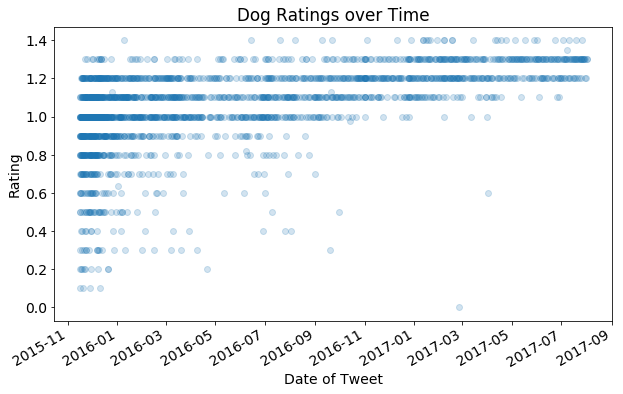

In [47]:
df_tweets_analysis = df_tweets_clean.copy()

plt.rcParams.update({'font.size': 14})

df_tweets_analysis.plot(
    x='timestamp', y='rating', style='o', alpha=0.2,
    figsize=(10,6), legend=False, title='Dog Ratings over Time'
);
plt.xlabel('Date of Tweet')
plt.ylabel('Rating');
plt.savefig('analysis_q1.png');

> Indeed, there appears to be a trend towards higher ratings over time, which is more conspicuous given the dramatic decrease in frequency of sub-10/10 ratings. Let's run a linear regression to quantify the overall trend. Now we'll have to give in and convert the timestamp to a numeric value.

In [48]:
# Credit: https://stackoverflow.com/a/45886455/576101
def timestamp_to_seconds(timestamp):
    return time.mktime(timestamp.timetuple())

earliest_timestamp = df_tweets_analysis['timestamp'].min()
base_seconds = timestamp_to_seconds(earliest_timestamp)

def seconds_after_earliest_tweet(timestamp):
    return timestamp_to_seconds(timestamp) - base_seconds

def seconds_to_days(seconds):
    return seconds / 60 / 60 / 24

df_tweets_analysis['days_since_start'] = (
    df_tweets_analysis
    .timestamp
    .apply(seconds_after_earliest_tweet)
    .apply(seconds_to_days)
)

df_tweets_analysis['intercept'] = 1
sm.OLS(
    df_tweets_analysis['rating'],
    df_tweets_analysis[['days_since_start', 'intercept']]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     786.0
Date:                Mon, 10 Dec 2018   Prob (F-statistic):          9.17e-146
Time:                        15:01:55   Log-Likelihood:                 538.09
No. Observations:                1967   AIC:                            -1072.
Df Residuals:                    1965   BIC:                            -1061.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
days_since_start     0.0006   2.23e-05     28.035      0.000       0.001       0.001
intercept            0.9328      0.006    155.991      0.000       0.921       0.945
==============================================================================
Omnibus:                      665.383   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2578.456
Skew:                          -1.622   Prob(JB):                         0.00
Kurtosis:                       7.575   Cond. No.                         387.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> We have a p-value smaller than 0.001 for our positive linear relationship between `days_since_start` and `rating`. The (adjusted) R-squared value is also substantial at 0.285, meaning that 28.5% of the variance of the ratings is accounted for by the dates on which the ratings was given.

## Question 2:  Is there a correlation between favorites and retweets?

> Once again, let's begin with a scatter plot.

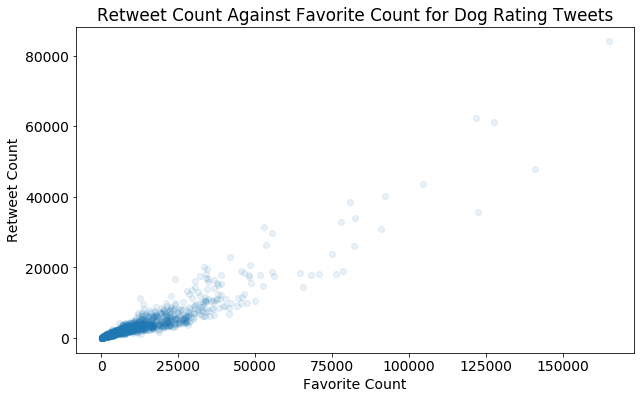

In [49]:
x = df_tweets_analysis.favorite_count
y = df_tweets_analysis.retweet_count
plt.figure(figsize=(10, 6))
plt.scatter(x=x, y=y, alpha=0.1);
plt.title('Retweet Count Against Favorite Count for Dog Rating Tweets');
plt.xlabel('Favorite Count');
plt.ylabel('Retweet Count');
plt.savefig('analysis_q2.png');

> As expected, there does appear to be a strong positive correlation between the favorite and retweet counts. Let's zoom in on that dense region in the bottom left corner of the graph.

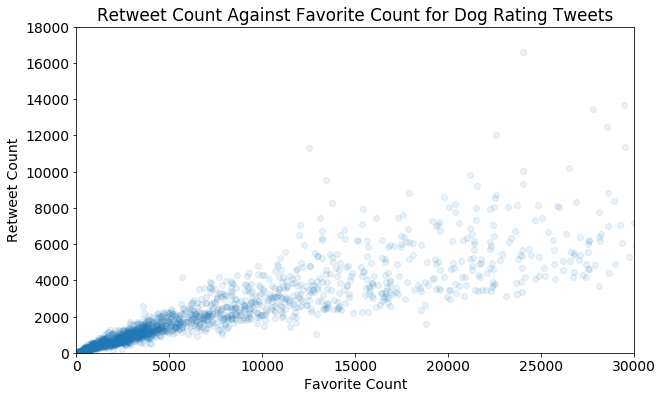

In [50]:
plt.figure(figsize=(10, 6))
plt.scatter(x=x, y=y, alpha=0.1);
plt.title('Retweet Count Against Favorite Count for Dog Rating Tweets');
plt.xlabel('Favorite Count');
plt.ylabel('Retweet Count');
plt.xlim(0, 30000);
plt.ylim(0, 18000);

> The relationship is strongly linear here. Let's quantify the linear correlation (across the full range of our data).

In [51]:
sm.OLS(
    df_tweets_analysis['retweet_count'],
    df_tweets_analysis[['favorite_count', 'intercept']]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          retweet_count   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                 1.254e+04
Date:                Mon, 10 Dec 2018   Prob (F-statistic):               0.00
Time:                        15:01:56   Log-Likelihood:                -17488.
No. Observations:                1967   AIC:                         3.498e+04
Df Residuals:                    1965   BIC:                         3.499e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
favorite_count     0.3439      0.003    111.983      0.000       0.338       0.350
intercept       -350.0832     48.014     -7.291      0.000    -444.246    -255.920
==============================================================================
Omnibus:                     1757.225   Durbin-Watson:                   1.252
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           230794.917
Skew:                           3.641   Prob(JB):                         0.00
Kurtosis:                      55.564   Cond. No.                     1.89e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

> We have a very strong linear relationship with 86.4% of the variance of one count being accounted for by the other.

## Question 3: Do tweets with positive dog predictions have higher ratings?

> We want to partition the data into two subsets -- one containing only the tweets having p1_dog = True, and one containing only the tweets having p1_dog = False. Let's first create a plot to compare the rating distributions of each of these subsets visually. Since, a point plot would allow us to place both distributions onto a single plot for easy comparison, let's create a point plot with ratings along the x axis and counts, normalized within each group, along the y axis. We'll have to do the normalization part ourselves, since the kind of normalization we want doesn't come with the libraries.

In [52]:
# Get the counts for each subset, for normalization.
is_dog_counts = df_tweets_analysis.groupby('p1_dog').tweet_id.count()
is_dog_counts

p1_dog
False     506
True     1461
Name: tweet_id, dtype: int64

In [53]:
# Round all ratings to their nearest tenth.
df_tweets_analysis['rating_rounded'] = (
    df_tweets_analysis.rating.apply(lambda x: round(x, 1))
)
df_tweets_analysis[
    df_tweets_analysis.rating != df_tweets_analysis.rating_rounded
][['rating', 'rating_rounded']]

,rating,rating_rounded
39,1.350000,1.4
498,0.975000,1.0
548,1.127000,1.1
791,0.818182,0.8
1310,0.636364,0.6
1356,1.126000,1.1


In [54]:
# Form a dataframe for the plot and normalize the counts.
df_q3 = (
    df_tweets_analysis
    .groupby(['p1_dog', 'rating_rounded'])
    .tweet_id.count()
    .to_frame().reset_index()
    .rename(columns={'tweet_id': 'count'})
)
df_q3['normalized_count'] = df_q3.apply(
    lambda r: r['count'] / is_dog_counts[r.p1_dog], axis=1
)
df_q3.head()

,p1_dog,rating_rounded,count,normalized_count
0,False,0.0,1,0.001976
1,False,0.1,4,0.007905
2,False,0.2,8,0.015810
3,False,0.3,16,0.031621
4,False,0.4,11,0.021739


In [55]:
# Verify that each normalization equals 1.
df_q3.groupby('p1_dog').normalized_count.sum()

p1_dog
False    1.0
True     1.0
Name: normalized_count, dtype: float64

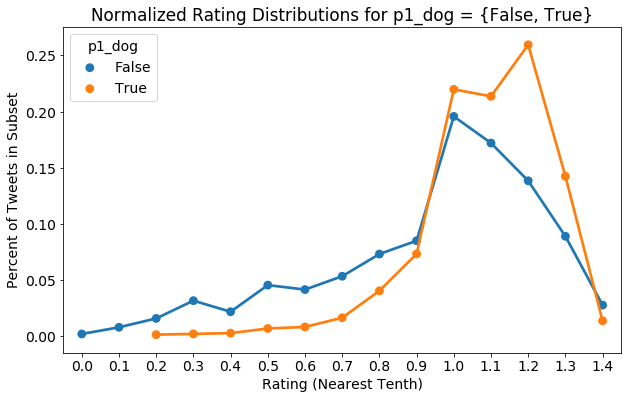

In [56]:
# Plot.
plt.figure(figsize=(10, 6))
sns.pointplot(
    data=df_q3, x='rating_rounded', y='normalized_count', hue='p1_dog'
);
plt.title('Normalized Rating Distributions for p1_dog = {False, True}');
plt.xlabel('Rating (Nearest Tenth)')
plt.ylabel('Percent of Tweets in Subset');
plt.savefig('analysis_q3.png');

> Indeed, the p1_dog=False group has a thicker tail on the left. The p1_dog=True tweets appear to have higher ratings on average. Let's see if the difference is statistically significant. We'll use hypothesis testing on bootstrapped samples with a null hypothesis that the mean of the p1_dog=False ratings is greater than or equal to the mean of the p1_dog=True ratings.

In [57]:
def new_sample_mean(series):
    new_sample = series.sample(len(series), replace=True)
    return new_sample.mean()

def sample_mean_diffs(series1, series2, n_samples):
    return np.array([
        new_sample_mean(series1) - new_sample_mean(series2)
        for i in range(n_samples)
    ])

dog_ratings = df_tweets_analysis[df_tweets_analysis.p1_dog].rating
non_dog_ratings = df_tweets_analysis[~df_tweets_analysis.p1_dog].rating
sample_rating_mean_diffs = sample_mean_diffs(non_dog_ratings, dog_ratings, 5000)
null_hypothesis = sample_rating_mean_diffs >= 0
p_value = null_hypothesis.mean()
print(
    p_value,
    non_dog_ratings.mean(),
    dog_ratings.mean(),
    dog_ratings.mean() - non_dog_ratings.mean()
)

0.0 0.947305066475027 1.090209570032982 0.14290450355795492


> With a p-value of 0 < 0.05, we have a statistically significant result, and the difference between the means is about 0.14, or 1.4/10 on the standard rating scale, which seems like a practically significant difference.

In [58]:
df_tweets_tidy[df_tweets_tidy.name =='None'].name.count()

745